#### Imports 

In [1]:
# import libraries
import pandas as pd
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.tsa.stattools as sts 
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2
from datetime import timedelta
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 7
%matplotlib inline

##### Load Dataset

In [2]:
df = pd.read_csv('covid_19_data.csv')

#### Data Cleaning 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8509 entries, 0 to 8508
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SNo              8509 non-null   int64  
 1   ObservationDate  8509 non-null   object 
 2   Province/State   4761 non-null   object 
 3   Country/Region   8509 non-null   object 
 4   Last Update      8509 non-null   object 
 5   Confirmed        8509 non-null   float64
 6   Deaths           8509 non-null   float64
 7   Recovered        8509 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 531.9+ KB


In [4]:
df.isnull().sum()

SNo                   0
ObservationDate       0
Province/State     3748
Country/Region        0
Last Update           0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64

In [5]:
df['Province/State'].unique()

array(['Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong',
       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hong Kong', 'Hubei', 'Hunan', 'Inner Mongolia', 'Jiangsu',
       'Jiangxi', 'Jilin', 'Liaoning', 'Macau', 'Ningxia', 'Qinghai',
       'Shaanxi', 'Shandong', 'Shanghai', 'Shanxi', 'Sichuan', 'Taiwan',
       'Tianjin', 'Tibet', 'Washington', 'Xinjiang', 'Yunnan', 'Zhejiang',
       nan, 'Chicago', 'Illinois', 'California', 'Arizona', 'Ontario',
       'New South Wales', 'Victoria', 'British Columbia', 'Bavaria',
       'Queensland', 'Chicago, IL', 'South Australia', 'Boston, MA',
       'Los Angeles, CA', 'Orange, CA', 'Santa Clara, CA', 'Seattle, WA',
       'Tempe, AZ', 'San Benito, CA', 'Toronto, ON', 'London, ON',
       'Madison, WI', 'Cruise Ship', 'Diamond Princess cruise ship',
       'San Diego County, CA', 'San Antonio, TX', 'Ashland, NE',
       'Travis, CA', 'From Diamond Princess', 'Lackland, TX', 'None',
       'Humboldt

In [6]:
df["ObservationDate"]=pd.to_datetime(df["ObservationDate"])

In [7]:
bydate=df.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
bydate.head()

,Confirmed,Recovered,Deaths
ObservationDate,,,
2020-01-22,555.0,28.0,17.0
2020-01-23,653.0,30.0,18.0
2020-01-24,941.0,36.0,26.0
2020-01-25,1438.0,39.0,42.0
2020-01-26,2118.0,52.0,56.0


#### EDA 

In [8]:
print("Basic Information")
print("Totol number of countries with Disease Spread: ",len(df["Country/Region"].unique()))
print("Total number of Confirmed Cases: ",bydate["Confirmed"].iloc[-1])
print("Total number of Recovered Cases: ",bydate["Recovered"].iloc[-1])
print("Total number of Deaths Cases: ",bydate["Deaths"].iloc[-1])
print("Total number of Active Cases around the World: ",(bydate["Confirmed"].iloc[-1]-bydate["Recovered"].iloc[-1]))

Basic Information
Totol number of countries with Disease Spread:  205
Total number of Confirmed Cases:  417966.0
Total number of Recovered Cases:  107705.0
Total number of Deaths Cases:  18615.0
Total number of Active Cases around the World:  310261.0


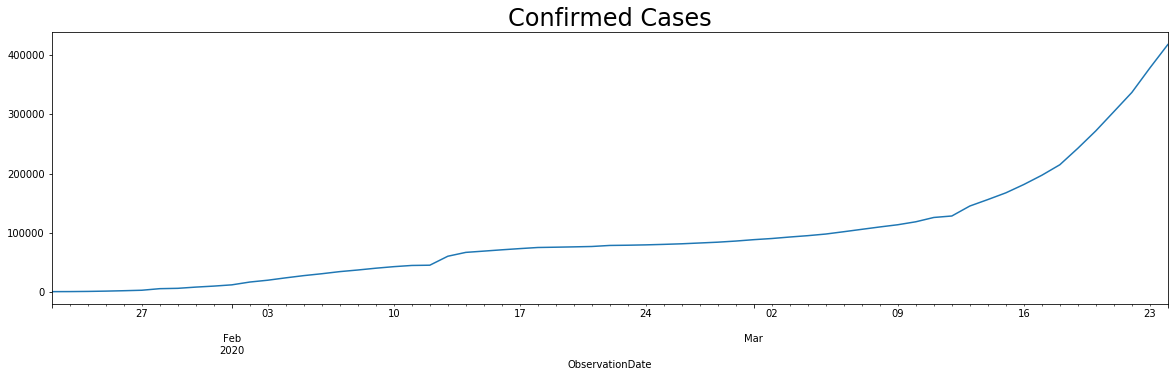

In [9]:
bydate.Confirmed.plot(figsize = (20,5))
plt.title("Confirmed Cases", size= 24)
plt.show()

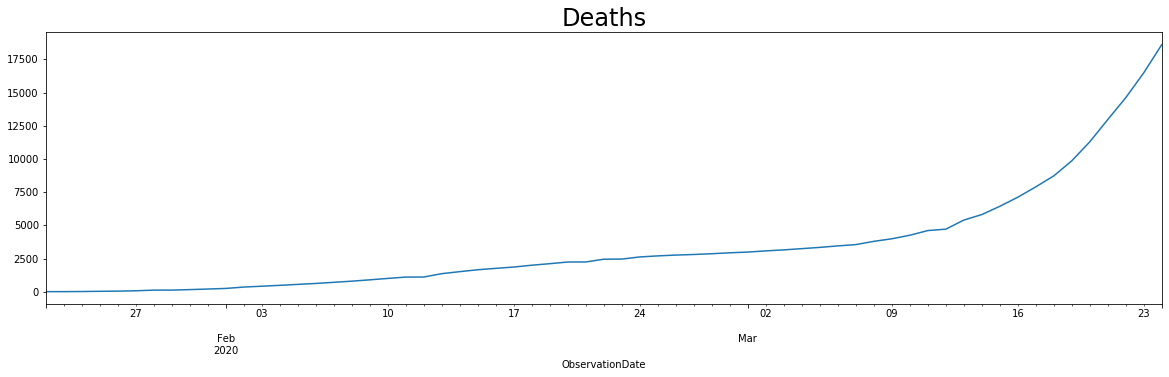

In [10]:
bydate.Deaths.plot(figsize = (20,5))
plt.title("Deaths", size= 24)
plt.show()

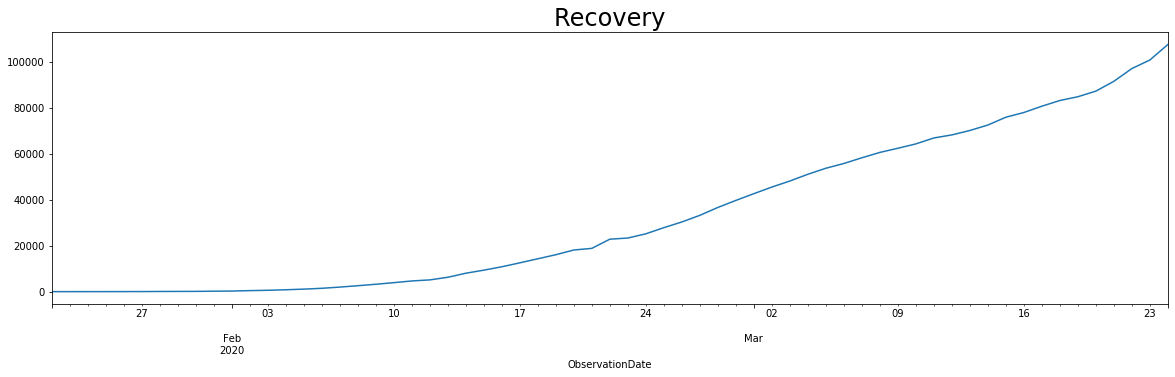

In [11]:
bydate.Recovered.plot(figsize = (20,5))
plt.title("Recovery", size= 24)
plt.show()

#### Models 

##### Train_test_split

In [12]:
size = int(len(bydate)*0.8)

In [13]:
df_train, df_test = bydate.iloc[:size], bydate.iloc[size:]

In [14]:
y_pred = df_test.copy()

In [15]:
log_series=np.log(df_train["Confirmed"])

In [16]:
log_deaths = np.log(df_train["Deaths"])

In [17]:
log_recover = np.log(df_train["Recovered"])

##### Dickey-fuller test 

###### Confirmed

In [18]:
sts.adfuller(df_train.Confirmed)

(0.5121314298729323,
 0.9852371943124696,
 1,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 706.3376933328723)

In [19]:
sts.adfuller(log_series)

(-9.595349512798009,
 1.9851767635488026e-16,
 0,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 -127.31164931014973)

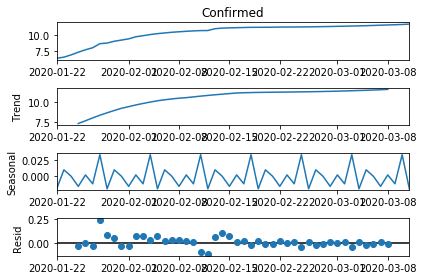

In [20]:
sm.tsa.seasonal_decompose(log_series).plot()
plt.show()

###### DEATH

In [21]:
sts.adfuller(df_train.Deaths)

(1.4813772495290378,
 0.997454211158325,
 2,
 47,
 {'1%': -3.5778480370438146,
  '5%': -2.925338105429433,
  '10%': -2.6007735310095064},
 424.6115470665611)

In [22]:
sts.adfuller(log_deaths)

(-8.530075001750804,
 1.0434480638787225e-13,
 0,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 -150.51257722516857)

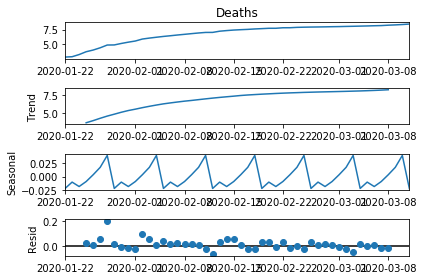

In [23]:
sm.tsa.seasonal_decompose(log_deaths).plot()
plt.show()

###### RECOVERED

In [24]:
sts.adfuller(df_train.Recovered)

(-0.951811619469739,
 0.7704319140303657,
 3,
 46,
 {'1%': -3.5812576580093696,
  '5%': -2.9267849124681518,
  '10%': -2.6015409829867675},
 599.3596953932226)

In [25]:
sts.adfuller(log_recover)

(-4.659208674660239,
 0.00010032390918684565,
 1,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 -149.46592512990446)

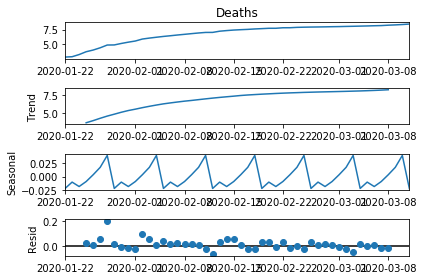

In [26]:
sm.tsa.seasonal_decompose(log_deaths).plot()
plt.show()

##### AR model Confirmed Cases

In [27]:
model_ar=ARIMA(log_series,(5,1,0))
model_ar_fit=model_ar.fit()

/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [28]:
prediction_ar= model_ar_fit.forecast(len(df_test))[0]
y_pred["AR Model Prediction"]=list(np.exp(prediction_ar))

In [106]:
y_pred

,Confirmed,Recovered,Deaths,AR Model Prediction,AR Model Prediction_death,MA Model Prediction,ARIMA Model Prediction,AR Model Prediction_Recover,MA Model Prediction_death,MA Model Prediction_recover,ARIMA Model Prediction_death,ARIMA Model Prediction_recover
ObservationDate,,,,,,,,,,,,
2020-03-12,128343.0,68324.0,4720.0,133018.485724,4946.186564,135019.851963,133094.331836,70279.662846,5077.721621,73539.392373,5010.093417,70201.125445
2020-03-13,145193.0,70251.0,5404.0,141862.088082,5373.621925,146515.902416,141787.362645,73953.135283,5541.900890,79284.675032,5488.857165,73685.904096
2020-03-14,156099.0,72624.0,5819.0,151931.018194,5869.432503,160663.445307,151746.127830,78019.546506,6029.550295,86799.446713,6056.015188,77736.916815
2020-03-15,167447.0,76034.0,6440.0,163230.286686,6387.113848,177771.284662,163101.205559,82546.239383,6707.979814,95961.476865,6712.860888,82401.039414
2020-03-16,181546.0,78088.0,7126.0,176207.774386,7021.089955,197790.462104,176004.463323,87694.530871,7495.862532,108088.616599,7463.666520,87734.294564
2020-03-17,197168.0,80840.0,7905.0,190845.839912,7728.273557,220292.931731,190631.246337,93515.075544,8376.462598,125276.663691,8315.078142,93802.537257
2020-03-18,214915.0,83313.0,8733.0,207397.080902,8506.236028,245355.490120,207182.990417,100029.198611,9360.513931,145197.921477,9275.803697,100682.333164
2020-03-19,242713.0,84962.0,9867.0,226118.058942,9424.441301,273269.396612,225890.290384,107312.391725,10460.169794,168287.019946,10356.472718,108462.034857
2020-03-20,272167.0,87403.0,11299.0,247231.783832,10442.679013,304359.046900,247016.465421,115437.185485,11689.011194,195047.703122,11569.605447,117243.066410


(array([737446., 737456., 737463., 737470., 737477., 737485., 737492.,
        737499., 737506.]), <a list of 9 Text xticklabel objects>)

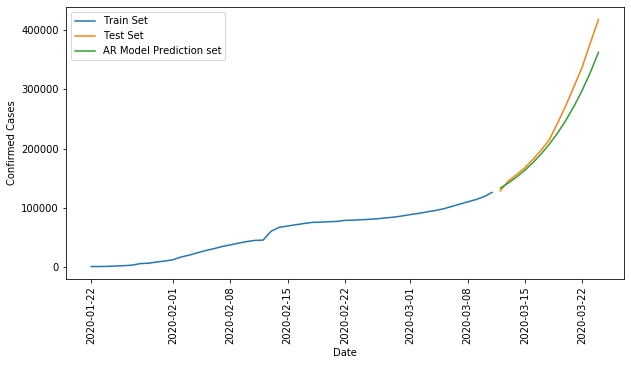

In [29]:
plt.figure(figsize=(10,5))
plt.plot(df_train.index,df_train["Confirmed"],label="Train Set")
plt.plot(df_test.index,df_test["Confirmed"],label="Test Set")
plt.plot(y_pred["AR Model Prediction"],label="AR Model Prediction set")
plt.legend()
plt.xlabel("Date")
plt.ylabel('Confirmed Cases')
plt.xticks(rotation=90)

In [45]:
model_predictions=pd.DataFrame(zip(new_date),columns=["Dates"])

In [44]:
new_date=[]
AR_model_new_prediction=[]
for i in range(1,18):
    new_date.append(bydate.index[-1]+timedelta(days=i))
    AR_model_new_prediction.append(np.exp(model_ar_fit.forecast(len(df_test)+i)[0][-1]))

In [47]:
model_predictions["AR Model Prediction"]=AR_model_new_prediction

In [55]:
model_predictions

,Dates,AR Model Prediction,AR Model Prediction_death
0,2020-03-25,4.010200e+05,4.010200e+05
1,2020-03-26,4.445385e+05,4.445385e+05
2,2020-03-27,4.936504e+05,4.936504e+05
3,2020-03-28,5.490882e+05,5.490882e+05
4,2020-03-29,6.116853e+05,6.116853e+05
5,2020-03-30,6.823873e+05,6.823873e+05
6,2020-03-31,7.622681e+05,7.622681e+05
7,2020-04-01,8.525476e+05,8.525476e+05
8,2020-04-02,9.546108e+05,9.546108e+05
9,2020-04-03,1.070031e+06,1.070031e+06


##### AR Death cases

In [57]:
model_ar_death=ARIMA(log_deaths,(5,1,0))
results_ar_death=model_ar_death.fit()

/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [58]:
prediction_ar_death= results_ar_death.forecast(len(df_test))[0]
y_pred["AR Model Prediction_death"]=list(np.exp(prediction_ar_death))

(array([737446., 737456., 737463., 737470., 737477., 737485., 737492.,
        737499., 737506.]), <a list of 9 Text xticklabel objects>)

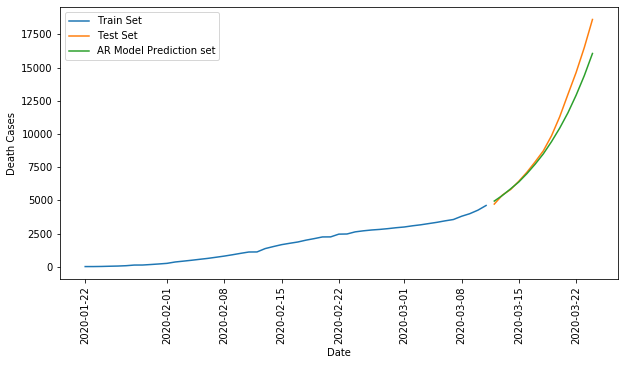

In [59]:
plt.figure(figsize=(10,5))
plt.plot(df_train.index,df_train["Deaths"],label="Train Set")
plt.plot(df_test.index,df_test["Deaths"],label="Test Set")
plt.plot(y_pred["AR Model Prediction_death"],label="AR Model Prediction set")
plt.legend()
plt.xlabel("Date")
plt.ylabel('Death Cases')
plt.xticks(rotation=90)

In [82]:
AR_model_new_prediction_death=[]
for i in range(1,18):
    AR_model_new_prediction_death.append(np.exp(results_ar_death.forecast(len(df_test)+i)[0][-1]))
model_predictions["AR Model Prediction_death"]=AR_model_new_prediction_death

##### AR RECOVERED

In [62]:
model_ar_recover=ARIMA(log_recover,(5,1,0))
results_ar_recover=model_ar_recover.fit()

/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [63]:
prediction_ar_recover= results_ar_recover.forecast(len(df_test))[0]
y_pred["AR Model Prediction_Recover"]=list(np.exp(prediction_ar_recover))

(array([737446., 737456., 737463., 737470., 737477., 737485., 737492.,
        737499., 737506.]), <a list of 9 Text xticklabel objects>)

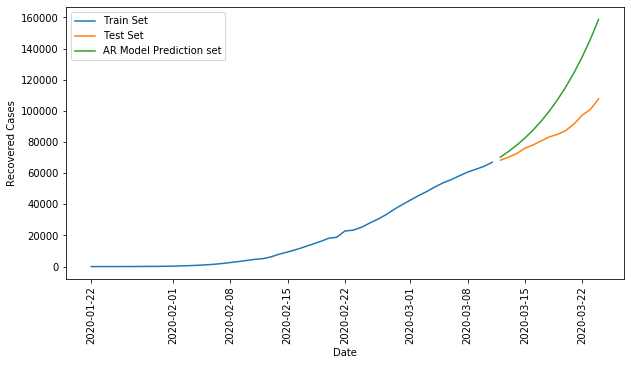

In [64]:
plt.figure(figsize=(10,5))
plt.plot(df_train.index,df_train["Recovered"],label="Train Set")
plt.plot(df_test.index,df_test["Recovered"],label="Test Set")
plt.plot(y_pred["AR Model Prediction_Recover"],label="AR Model Prediction set")
plt.legend()
plt.xlabel("Date")
plt.ylabel('Recovered Cases')
plt.xticks(rotation=90)

In [79]:
AR_model_new_prediction_recover=[]
for i in range(1,18):
    AR_model_new_prediction_recover.append(np.exp(results_ar_recover.forecast(len(df_test)+i)[0][-1]))
model_predictions["AR Model Prediction_Recover"]=AR_model_new_prediction_recover

##### MA model Confirmed Cases

In [34]:
model_ma=ARIMA(log_series,(0,1,5))
model_ma_fit=model_ma.fit()

/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [35]:
prediction_ma= model_ma_fit.forecast(len(df_test))[0]
y_pred["MA Model Prediction"]=list(np.exp(prediction_ma))

(array([737446., 737456., 737463., 737470., 737477., 737485., 737492.,
        737499., 737506.]), <a list of 9 Text xticklabel objects>)

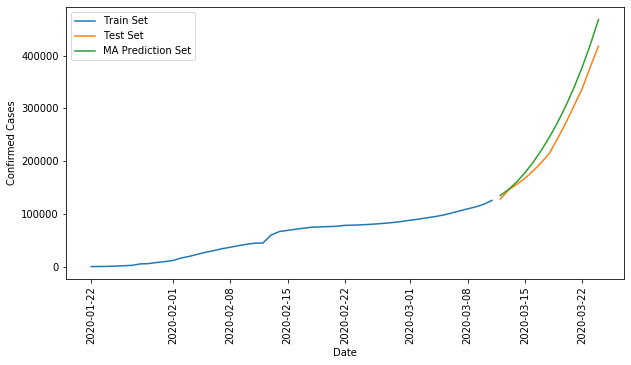

In [36]:
plt.figure(figsize=(10,5))
plt.plot(df_train.index,df_train["Confirmed"],label="Train Set")
plt.plot(df_test.index,df_test["Confirmed"],label="Test Set")
plt.plot(y_pred["MA Model Prediction"],label="MA Prediction Set")
plt.legend()
plt.xlabel("Date")
plt.ylabel('Confirmed Cases')
plt.xticks(rotation=90)

In [70]:
MA_model_new_prediction=[]
for i in range(1,18):
    MA_model_new_prediction.append(np.exp(model_ma_fit.forecast(len(df_test)+i)[0][-1]))
model_predictions["MA Model Prediction"]=MA_model_new_prediction

##### MA DEATH CASES

In [74]:
model_ma_death=ARIMA(log_deaths,(0,1,5))
results_ma__death=model_ma_death.fit()

/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [75]:
prediction_ma_death= results_ma__death.forecast(len(df_test))[0]
y_pred["MA Model Prediction_death"]=list(np.exp(prediction_ma_death))

(array([737446., 737456., 737463., 737470., 737477., 737485., 737492.,
        737499., 737506.]), <a list of 9 Text xticklabel objects>)

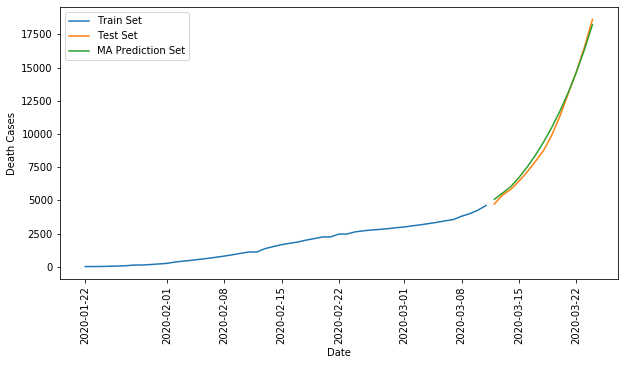

In [87]:
plt.figure(figsize=(10,5))
plt.plot(df_train.index,df_train["Deaths"],label="Train Set")
plt.plot(df_test.index,df_test["Deaths"],label="Test Set")
plt.plot(y_pred["MA Model Prediction_death"],label="MA Prediction Set")
plt.legend()
plt.xlabel("Date")
plt.ylabel('Death Cases')
plt.xticks(rotation=90)

In [84]:
MA_model_new_prediction_death=[]
for i in range(1,18):
    MA_model_new_prediction_death.append(np.exp(results_ma__death.forecast(len(df_test)+i)[0][-1]))
model_predictions["MA Model Prediction_death"]=MA_model_new_prediction_death

##### MA RECOVERED

In [85]:
model_ma_recover=ARIMA(log_recover,(0,1,5))
results_ma__recover=model_ma_recover.fit()

/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [86]:
prediction_ma_recover= results_ma__recover.forecast(len(df_test))[0]
y_pred["MA Model Prediction_recover"]=list(np.exp(prediction_ma_recover))

(array([737446., 737456., 737463., 737470., 737477., 737485., 737492.,
        737499., 737506.]), <a list of 9 Text xticklabel objects>)

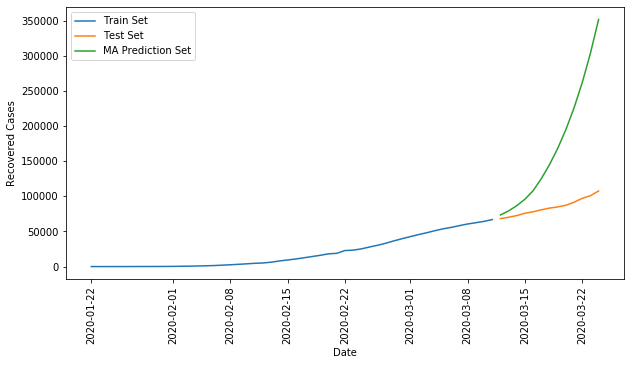

In [88]:
plt.figure(figsize=(10,5))
plt.plot(df_train.index,df_train["Recovered"],label="Train Set")
plt.plot(df_test.index,df_test["Recovered"],label="Test Set")
plt.plot(y_pred["MA Model Prediction_recover"],label="MA Prediction Set")
plt.legend()
plt.xlabel("Date")
plt.ylabel('Recovered Cases')
plt.xticks(rotation=90)

In [89]:
MA_model_new_prediction_recover=[]
for i in range(1,18):
    MA_model_new_prediction_recover.append(np.exp(results_ma__recover.forecast(len(df_test)+i)[0][-1]))
model_predictions["MA Model Prediction_death_recover"]=MA_model_new_prediction_recover

##### ARIMA Model Confirmed Cases

In [37]:
model_arima=ARIMA(log_series,(1,1,2))
model_arima_fit=model_arima.fit()

/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [38]:
prediction_arima=model_arima_fit.forecast(len(df_test))[0]
y_pred["ARIMA Model Prediction"]=list(np.exp(prediction_arima))

(array([737446., 737456., 737463., 737470., 737477., 737485., 737492.,
        737499., 737506.]), <a list of 9 Text xticklabel objects>)

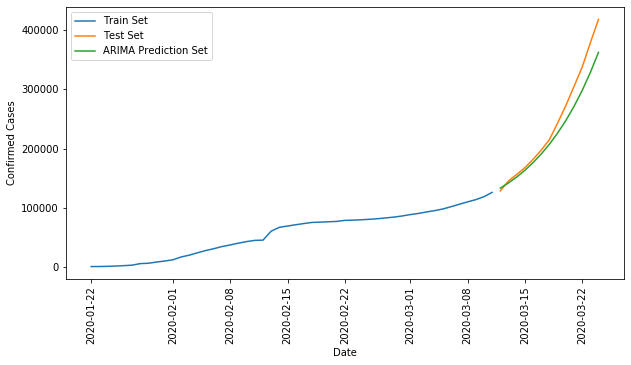

In [40]:
plt.figure(figsize=(10,5))
plt.plot(df_train.index,df_train["Confirmed"],label="Train Set")
plt.plot(df_test.index,df_test["Confirmed"],label="Test Set")
plt.plot(y_pred["ARIMA Model Prediction"],label="ARIMA Prediction Set")
plt.legend()
plt.xlabel("Date")
plt.ylabel('Confirmed Cases')
plt.xticks(rotation=90)

In [93]:
ARIMA_model_new_prediction=[]
for i in range(1,18):
    ARIMA_model_new_prediction.append(np.exp(model_arima_fit.forecast(len(df_test)+i)[0][-1]))
model_predictions["ARIMA Model Prediction"]=ARIMA_model_new_prediction

##### ARIMA DEATH

In [90]:
model_arima_death=ARIMA(log_deaths,(1,1,2))
results_arima_death=model_arima_death.fit()

/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [91]:
prediction_arima_death=results_arima_death.forecast(len(df_test))[0]
y_pred["ARIMA Model Prediction_death"]=list(np.exp(prediction_arima_death))

(array([737446., 737456., 737463., 737470., 737477., 737485., 737492.,
        737499., 737506.]), <a list of 9 Text xticklabel objects>)

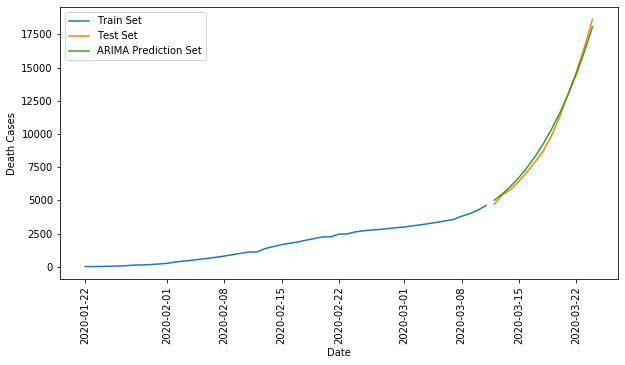

In [92]:
plt.figure(figsize=(10,5))
plt.plot(df_train.index,df_train["Deaths"],label="Train Set")
plt.plot(df_test.index,df_test["Deaths"],label="Test Set")
plt.plot(y_pred["ARIMA Model Prediction_death"],label="ARIMA Prediction Set")
plt.legend()
plt.xlabel("Date")
plt.ylabel('Death Cases')
plt.xticks(rotation=90)

In [94]:
ARIMA_model_new_prediction_death=[]
for i in range(1,18):
    ARIMA_model_new_prediction_death.append(np.exp(results_arima_death.forecast(len(df_test)+i)[0][-1]))
model_predictions["ARIMA Model Prediction_death"]=ARIMA_model_new_prediction_death

##### ARIMA RECOVERED

In [95]:
model_arima_recover=ARIMA(log_recover,(1,1,2))
results_arima_recover=model_arima_recover.fit()

/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [96]:
prediction_arima_recover=results_arima_recover.forecast(len(df_test))[0]
y_pred["ARIMA Model Prediction_recover"]=list(np.exp(prediction_arima_recover))

(array([737446., 737456., 737463., 737470., 737477., 737485., 737492.,
        737499., 737506.]), <a list of 9 Text xticklabel objects>)

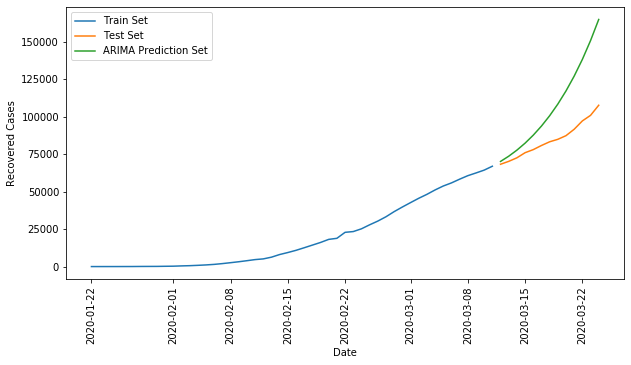

In [97]:
plt.figure(figsize=(10,5))
plt.plot(df_train.index,df_train["Recovered"],label="Train Set")
plt.plot(df_test.index,df_test["Recovered"],label="Test Set")
plt.plot(y_pred["ARIMA Model Prediction_recover"],label="ARIMA Prediction Set")
plt.legend()
plt.xlabel("Date")
plt.ylabel('Recovered Cases')
plt.xticks(rotation=90)

In [98]:
ARIMA_model_new_prediction_recover=[]
for i in range(1,18):
    ARIMA_model_new_prediction_recover.append(np.exp(results_arima_recover.forecast(len(df_test)+i)[0][-1]))
model_predictions["ARIMA Model Prediction_recover"]=ARIMA_model_new_prediction_recover

#### Final model

In [103]:
model_predictions

,Dates,AR Model Prediction,AR Model Prediction_death,AR Model Prediction_Recover,MA Model Prediction,MA Model Prediction_death,MA Model Prediction_death_recover,ARIMA Model Prediction,ARIMA Model Prediction_death,ARIMA Model Prediction_recover
0,2020-03-25,4.010200e+05,17961.557085,172846.497495,5.216297e+05,20369.153266,4.079359e+05,4.010098e+05,20203.069976,180844.608865
1,2020-03-26,4.445385e+05,20097.482761,188656.492741,5.809751e+05,22762.083716,4.728051e+05,4.446134e+05,22592.156383,198718.753085
2,2020-03-27,4.936504e+05,22525.218696,206325.104447,6.470722e+05,25436.131210,5.479897e+05,4.938283e+05,25264.516604,218831.385703
3,2020-03-28,5.490882e+05,25277.696828,226079.106354,7.206891e+05,28424.320857,6.351300e+05,5.493899e+05,28253.537559,241467.240881
4,2020-03-29,6.116853e+05,28377.387132,248174.259122,8.026814e+05,31763.557497,7.361271e+05,6.121331e+05,31596.594434,266949.341881
5,2020-03-30,6.823873e+05,31898.502262,272895.931705,8.940018e+05,35495.081481,8.531847e+05,6.830061e+05,35335.512888,295644.115053
6,2020-03-31,7.622681e+05,35882.396775,300573.353922,9.957117e+05,39664.978001,9.888565e+05,7.630853e+05,39517.088579,327967.205955
7,2020-04-01,8.525476e+05,40382.700514,331571.902503,1.108993e+06,44324.746251,1.146103e+06,8.535927e+05,44193.670082,364390.092195
8,2020-04-02,9.546108e+05,45489.446603,366308.675021,1.235162e+06,49531.935457,1.328354e+06,9.559162e+05,49423.812211,405447.600729
9,2020-04-03,1.070031e+06,51265.398007,405253.471960,1.375686e+06,55350.855618,1.539586e+06,1.071631e+06,55273.007679,451746.452203


In [105]:
y_pred # validation for the testing set 

,Confirmed,Recovered,Deaths,AR Model Prediction,AR Model Prediction_death,MA Model Prediction,ARIMA Model Prediction,AR Model Prediction_Recover,MA Model Prediction_death,MA Model Prediction_recover,ARIMA Model Prediction_death,ARIMA Model Prediction_recover
ObservationDate,,,,,,,,,,,,
2020-03-12,128343.0,68324.0,4720.0,133018.485724,4946.186564,135019.851963,133094.331836,70279.662846,5077.721621,73539.392373,5010.093417,70201.125445
2020-03-13,145193.0,70251.0,5404.0,141862.088082,5373.621925,146515.902416,141787.362645,73953.135283,5541.900890,79284.675032,5488.857165,73685.904096
2020-03-14,156099.0,72624.0,5819.0,151931.018194,5869.432503,160663.445307,151746.127830,78019.546506,6029.550295,86799.446713,6056.015188,77736.916815
2020-03-15,167447.0,76034.0,6440.0,163230.286686,6387.113848,177771.284662,163101.205559,82546.239383,6707.979814,95961.476865,6712.860888,82401.039414
2020-03-16,181546.0,78088.0,7126.0,176207.774386,7021.089955,197790.462104,176004.463323,87694.530871,7495.862532,108088.616599,7463.666520,87734.294564
2020-03-17,197168.0,80840.0,7905.0,190845.839912,7728.273557,220292.931731,190631.246337,93515.075544,8376.462598,125276.663691,8315.078142,93802.537257
2020-03-18,214915.0,83313.0,8733.0,207397.080902,8506.236028,245355.490120,207182.990417,100029.198611,9360.513931,145197.921477,9275.803697,100682.333164
2020-03-19,242713.0,84962.0,9867.0,226118.058942,9424.441301,273269.396612,225890.290384,107312.391725,10460.169794,168287.019946,10356.472718,108462.034857
2020-03-20,272167.0,87403.0,11299.0,247231.783832,10442.679013,304359.046900,247016.465421,115437.185485,11689.011194,195047.703122,11569.605447,117243.066410
